In [1]:
import json
from datetime import datetime, timezone, timedelta
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from helper import train_nlp_model, nlp_model_inference
import matplotlib.pyplot as plt
import requests

# In[1]
# Download news articles for ticker
nlp_api_url = ""
ticker = "BRENT"
body = {
  "tickers": {
    "tickers": [
      {
        "name": ticker,
        "industry_group": "oil",
        "search_terms": [
          "brent crude oil",
          "brent oil",
          "brent crude",
          "bz",
          "brent"
        ]
      }
    ]
  },
  "options": {
    "start_date": "2022-01-01T00:00:00+00:00",
    "end_date": "2022-07-22T00:00:00+00:00",
    "date_delta": timedelta(days=1).total_seconds(),
    "max_page_len": 100
  }
}

data_directory = "data"
downloaded_news = requests.post(nlp_api_url + "/news", json=body).json()
headlines_df = pd.DataFrame(downloaded_news[0]["articles"])
headlines_df["timestamp"] = pd.to_datetime(headlines_df["timestamp"])
print(f"Downloaded {len(headlines_df)} headlines")
print(headlines_df.head(10))
headlines = headlines_df["headline"].to_list()
headlines_df.to_csv(f"{data_directory}/{ticker}_downloaded_headlines.csv", index=False, header=False)

Downloaded 1735 headlines
                                            headline  \
0  Gervais' David Brent Was The Only Way To Save ...   
1  Brent Knoll's Sanders Garden Centre starts sec...   
2  OU football: Former Sooners offensive lineman ...   
3  FAU Football: Owls name Brent Dearmon offensiv...   
4  Oklahoma Football: Sack leaders during Brent V...   
5  Former CEO of Latitude 360 indicted on federal...   
6  Photos: Hundreds attend Brent Knoll's traditio...   
7  PHOTOS: Circus couple hold unique wedding unde...   
8  Montana State coach Brent Vigen looks to end F...   
9  Oklahoma AD Joe Castilgione and HC Brent Venab...   

                        source_link                        source  \
0            https://screenrant.com                   Screen Rant   
1    https://www.burnham-on-sea.com                Burnham-On-Sea   
2           https://www.oudaily.com            The Oklahoma Daily   
3      https://www.upressonline.com              University Press   
4  https://s

In[1]<br>
Get list of available NLP models

In [7]:
models = requests.get(nlp_api_url + "/models").json()
print(models)

{'models': [{'model_id': 'BRENT-relevancy-model-2022-08-16-08-16-49-520', 'training_job_status': 'Completed'}, {'model_id': 'ASTRAZENECA-sentiment-relevancy-model-2022-08-15-15-42-18-021', 'training_job_status': 'Completed'}, {'model_id': 'ASTRAZENECA-covid-relevancy-model-2022-08-15-14-51-36-745', 'training_job_status': 'Completed'}, {'model_id': 'ASTRAZENECA-relevancy-model-2022-08-15-14-18-11-143', 'training_job_status': 'Completed'}, {'model_id': 'BRENT-relevancy-model-2022-08-15-13-29-52-571', 'training_job_status': 'Completed'}, {'model_id': 'BRENT-relevancy-model-2022-08-15-13-28-53-177', 'training_job_status': 'Completed'}, {'model_id': 'BRENT-relevancy-model-2022-08-15-11-19-31-152', 'training_job_status': 'Completed'}, {'model_id': 'BRENT-relevancy-model-2022-08-12-08-26-26-136', 'training_job_status': 'Completed'}, {'model_id': 'BRENT-relevancy-model-2022-08-12-08-07-56-400', 'training_job_status': 'Completed'}, {'model_id': 'BRENT-relevancy-model-2022-08-11-15-42-46-424', '

In[2]<br>
Randomly sample headlines for relevancy model training and testing

In [6]:
random_relevancy_headlines_df = pd.DataFrame(random.sample(headlines, 150), columns=["headline"])
random_relevancy_headlines_df["label"] = "no"
relevancy_training_headlines_df, relevancy_testing_headlines_df = train_test_split(random_relevancy_headlines_df[["label","headline"]], test_size=0.4)
relevancy_training_headlines_df.to_csv(f"{data_directory}/{ticker}_relevancy_training_headlines.csv", index=False, header=False)
relevancy_testing_headlines_df.to_csv(f"{data_directory}/{ticker}_relevancy_testing_headlines.csv", index=False, header=False)
print(f"Label {data_directory}/{ticker}_relevancy_training_headlines.csv and {data_directory}/{ticker}_relevancy_training_headlines.csv before proceeding to training the model")

Label data/BRENT_relevancy_training_headlines.csv and data/BRENT_relevancy_training_headlines.csv before proceeding to training the model


LABEL WHETHER HEADLINES ARE RELEVANT TO TICKER

In[3]<br>
Train and test ticker relevancy model on saved labels

In [14]:
relevancy_model_id = train_nlp_model(f"{ticker}-relevancy-model", f"{data_directory}/{ticker}_relevancy_training_headlines.csv", nlp_api_url)
relevancy_inference_test_results = nlp_model_inference(relevancy_model_id, f"{data_directory}/{ticker}_relevancy_testing_headlines.csv", nlp_api_url, use_batch_inference=False)

Training BRENT-relevancy-model on data/BRENT_relevancy_training_headlines.csv. Data Size: 90. Training Data Sample:
  label                                               text
0    no  Why Brent Spiner Called His Time As Star Trek'...
1    no  Complemar Appoints Brent Dorfman President & C...
2    no  Columbus police arrest suspect for homicide by...
3    no  Brazil's Petrobras smashes all-time profit rec...
4    no     Playgroup marks 50th anniversary - Kent Online
{'model_id': 'BRENT-relevancy-model-2022-08-16-08-16-49-520', 'training_job_status': 'InProgress', 'detailed_job_status': 'Starting'}
Current status is InProgress. Sleeping for 30 seconds...
Current status is InProgress. Sleeping for 30 seconds...
Current status is InProgress. Sleeping for 30 seconds...
Current status is InProgress. Sleeping for 30 seconds...
Current status is InProgress. Sleeping for 30 seconds...
Current status is InProgress. Sleeping for 30 seconds...
Current status is InProgress. Sleeping for 30 seconds.

In[4]<br>
Get all relevant headlines using new relevancy model

In [9]:
random_headlines_df = pd.DataFrame(headlines, columns=["headline"])
relevancy_inference_results = nlp_model_inference(relevancy_model_id, random_headlines_df, nlp_api_url)
if "yes" in relevancy_inference_results:
    relevant_headlines_df = relevancy_inference_results[relevancy_inference_results["yes"] > relevancy_inference_results["no"]].reset_index()[["text"]]
    relevant_headlines_df.to_csv(f"{data_directory}/{ticker}_relevant_headlines.csv", index=False, header=False)
else:
    print("NO RELEVANT HEADLINES DETECTED")

Testing BRENT-relevancy-model-2022-08-16-08-16-49-520 on                                                    text
0     Former Penn State assistant officially joins B...
1     Unsigned Senior Spotlight: 6’3 Brent Randleman...
2     Brent Hughes promoted to head coach at Knoxvil...
3     Northwick Park Hospital: Armed forces help NHS...
4     Oil Prices for Jan. 05, 2022: Brent Crude, WTI...
...                                                 ...
1730  Author Brent W. Ratajczak's new book, 'Beautif...
1731  Brent Faiyaz Debuts On Top Ten With ‘Wasteland...
1732  Brent fire live: Updates from North West Londo...
1733  Guilty: Man murdered woman in Brent shipping c...
1734  Bahrain News: Pint-sized Brent hits right note...

[1735 rows x 1 columns]. Data Size: 1735. Training Data Sample:
                                                text
0  Former Penn State assistant officially joins B...
1  Unsigned Senior Spotlight: 6’3 Brent Randleman...
2  Brent Hughes promoted to head coach at Knoxv

Or Load saved relevant topic headlines<br>

In [12]:
relevant_headlines_df = pd.read_csv(f"{data_directory}/{ticker}_relevant_headlines.csv", encoding = "ISO-8859-1")
relevant_headlines_df.columns = ["text"]
print(relevant_headlines_df.head(10))

                                                text
0  Brent oil jumps to highest level in 7 years - ...
1  Tight supply pushes Brent oil above $87, its h...
2  Abu Dhabi oil site attack push Brent prices hi...
3  Global benchmark Brent climbs to more than 7-y...
4  Oil Likely To Get Costlier As Brent Crude Pric...
5  Brent at 7-year high: how are economy, markets...
6  Dated Brent assessed above $90/b for first tim...
7  Midday update for Brent oil 24-01-2022 - Econo...
8  Brent oil hits $91 a barrel as Ukraine worries...
9  Russian February domestic crude prices surge o...


In[4]<br>
Randomly sample from relevant headlines for topic relevancy model training and testing

In [ ]:
topic = "price"
topic_relevant_headlines_df = relevant_headlines_df.copy()
topic_relevant_headlines_df["label"] = "no"
topic_relevant_headlines_labelling_df = topic_relevant_headlines_df.sample(150)
relevancy_training_headlines_df, relevancy_testing_headlines_df = train_test_split(topic_relevant_headlines_labelling_df[["label","text"]], test_size=0.4)
relevancy_training_headlines_df.to_csv(f"{data_directory}/{ticker}_{topic}_relevancy_training_headlines.csv", index=False, header=False)
relevancy_testing_headlines_df.to_csv(f"{data_directory}/{ticker}_{topic}_relevancy_testing_headlines.csv", index=False, header=False)
print(f"Label {data_directory}/{ticker}_{topic}_relevancy_training_headlines.csv and {data_directory}/{ticker}_{topic}_relevancy_testing_headlines.csv before proceeding to training the model")

LABEL WHETHER HEADLINES ARE RELEVANT TO TOPIC

In[5]<br>
Train and test topic relevancy model on saved labels

In [ ]:
topic_model_id = train_nlp_model(f"{ticker}-{topic}-relevancy-model", f"{data_directory}/{ticker}_{topic}_relevancy_training_headlines.csv", nlp_api_url)
relevancy_inference_test_results = nlp_model_inference(topic_model_id, f"{data_directory}/{ticker}_{topic}_relevancy_testing_headlines.csv", nlp_api_url, use_batch_inference=False)

Training BRENT-price-relevancy-model on data/BRENT_price_relevancy_training_headlines.csv. Data Size: 90. Training Data Sample:
  label                                               text
0   yes  Oil price drop: Brent crude dips as European U...
1   yes  Brent Seen Averaging $104 in 2022, but Uncerta...
2   yes  Abu Dhabi oil site attack push Brent prices hi...
3   yes  Oil prices rise on Saudi crude hike; Brent rea...
4   yes  US gasoline prices fall to lowest since May, B...
{'model_id': 'BRENT-price-relevancy-model-2022-08-16-08-50-02-282', 'training_job_status': 'InProgress', 'detailed_job_status': 'Starting'}
Current status is InProgress. Sleeping for 30 seconds...
Current status is InProgress. Sleeping for 30 seconds...
Current status is InProgress. Sleeping for 30 seconds...
Current status is InProgress. Sleeping for 30 seconds...
Current status is InProgress. Sleeping for 30 seconds...
Current status is InProgress. Sleeping for 30 seconds...
Current status is InProgress. Sleepi

In[7]<br>
Get all relevant headlines using new topic relevancy model

In [ ]:
topic_relevancy_inference_results = nlp_model_inference(topic_model_id, relevant_headlines_df, nlp_api_url)
if "yes" in topic_relevancy_inference_results:
    topic_relevant_headlines_df = topic_relevancy_inference_results[topic_relevancy_inference_results["yes"] > topic_relevancy_inference_results["no"]].reset_index()[["text"]]
    topic_relevant_headlines_df.to_csv(f"{data_directory}/{ticker}_{topic}_relevant_headlines.csv", index=False, header=False)
    print(topic_relevant_headlines_df.head(10))
else:
    print("NO RELEVANT HEADLINES DETECTED")

Testing BRENT-price-relevancy-model-2022-08-16-08-50-02-282 on                                                   text
0    Brent oil jumps to highest level in 7 years - ...
1    Tight supply pushes Brent oil above $87, its h...
2    Abu Dhabi oil site attack push Brent prices hi...
3    Global benchmark Brent climbs to more than 7-y...
4    Oil Likely To Get Costlier As Brent Crude Pric...
..                                                 ...
294  Weaker Pound and Energy Price Jump Means Â£100...
295  Column: Brent bulls get a boost from EU sancti...
296  Fitch revises end-year Brent crude price to $1...
297  Oil prices drop on inflation concerns, Brent c...
298  Ichimoku cloud analysis: GBP/USD, brent, USD/J...

[299 rows x 1 columns]. Data Size: 299. Training Data Sample:
                                                text
0  Brent oil jumps to highest level in 7 years - ...
1  Tight supply pushes Brent oil above $87, its h...
2  Abu Dhabi oil site attack push Brent prices hi...
3 

In[8]<br>
Label all relevant headlines with pre-trained general sentiment model

In [15]:
sentiment_model_id = "fin-news-sentiment-test-2022-08-16-15-57-44-907"
sentiment_inference_results = nlp_model_inference(sentiment_model_id, topic_relevant_headlines_df, nlp_api_url)
sentiment_inference_results["sentiment_score"] = 1*sentiment_inference_results["positive"] + -1*sentiment_inference_results["negative"]
sentiment_training_headlines_df, sentiment_testing_headlines_df = train_test_split(sentiment_inference_results[["predicted_label","text"]] if len(sentiment_inference_results) < 150 else sentiment_inference_results[["predicted_label","text"]].sample(150), test_size=0.4)
sentiment_training_headlines_df.to_csv(f"{data_directory}/{ticker}_{topic}_sentiment_training_headlines.csv", index=False, header=False)
sentiment_testing_headlines_df.to_csv(f"{data_directory}/{ticker}_{topic}_sentiment_testing_headlines.csv", index=False, header=False)
print(f"Label {data_directory}/{ticker}_{topic}_sentiment_training_headlines.csv and {data_directory}/{ticker}_{topic}_sentiment_testing_headlines.csv before proceeding to training the model")

Testing fin-news-sentiment-multilabel-2021-12-01-16-35-04-096 on                                                   text
0    Brent oil jumps to highest level in 7 years - ...
1    Tight supply pushes Brent oil above $87, its h...
2    Abu Dhabi oil site attack push Brent prices hi...
3    Oil Likely To Get Costlier As Brent Crude Pric...
4    Brent at 7-year high: how are economy, markets...
..                                                 ...
233  Commodity Superfast: Selling Trend Picks Up In...
234  Weaker Pound and Energy Price Jump Means Â£100...
235  Column: Brent bulls get a boost from EU sancti...
236  Fitch revises end-year Brent crude price to $1...
237  Oil prices drop on inflation concerns, Brent c...

[238 rows x 1 columns]. Data Size: 238. Training Data Sample:
                                                text
0  Brent oil jumps to highest level in 7 years - ...
1  Tight supply pushes Brent oil above $87, its h...
2  Abu Dhabi oil site attack push Brent prices hi...


LABEL HEADLINE SENTIMENT ACCORDING TO TOPIC

In[9]<br>
Train and test topic sentiment model on saved labels

In [ ]:
ticker_sentiment_model_id = train_nlp_model(f"{ticker}-sentiment-relevancy-model", f"{data_directory}/{ticker}_{topic}_sentiment_training_headlines.csv", nlp_api_url)
sentiment_inference_test_results = nlp_model_inference(ticker_sentiment_model_id, f"{data_directory}/{ticker}_{topic}_sentiment_testing_headlines.csv", nlp_api_url, use_batch_inference=False)

Training BRENT-sentiment-relevancy-model on data/BRENT_price_sentiment_training_headlines.csv. Data Size: 90. Training Data Sample:
      label                                               text
0  positive  Brent over $100 with lifting force majeure on ...
1  positive  Brent surpasses $109 mark as oil posts gains -...
2  positive  Brent oil price achieves strong gains Ã¢ÂÂ A...
3   neutral  India trims jet fuel prices as Brent hovers ar...
4  positive  Brent oil price achieves more gains Ã¢ÂÂ Ana...
{'model_id': 'BRENT-sentiment-relevancy-model-2022-08-16-09-44-51-133', 'training_job_status': 'InProgress', 'detailed_job_status': 'Starting'}
Current status is InProgress - Starting. Sleeping for 30 seconds...
Current status is InProgress - Starting. Sleeping for 30 seconds...
Current status is InProgress - Starting. Sleeping for 30 seconds...
Current status is InProgress - Starting. Sleeping for 30 seconds...
Current status is InProgress - Downloading. Sleeping for 30 seconds...
Cur

In[10]<br>
Run topic sentiment inference on all relevant articles

In [17]:
sentiment_inference_all_results = nlp_model_inference(ticker_sentiment_model_id, topic_relevant_headlines_df, nlp_api_url)
print(sentiment_inference_all_results.head(10))
sentiment_inference_all_results_info = (sentiment_inference_all_results.merge(headlines_df, left_on='text', right_on='headline')
          .reindex(columns=['timestamp', 'headline', 'source', 'source_link', 'positive', 'neutral', 'negative']))
print(sentiment_inference_all_results_info.head(10))
sentiment_inference_all_results_info.to_csv(f"{data_directory}/{ticker}_{topic}_sentiment_all_headlines.csv", index=False)

Testing BRENT-sentiment-relevancy-model-2022-08-16-09-22-05-757 on                                                   text
0    Brent oil jumps to highest level in 7 years - ...
1    Tight supply pushes Brent oil above $87, its h...
2    Abu Dhabi oil site attack push Brent prices hi...
3    Oil Likely To Get Costlier As Brent Crude Pric...
4    Brent at 7-year high: how are economy, markets...
..                                                 ...
233  Commodity Superfast: Selling Trend Picks Up In...
234  Weaker Pound and Energy Price Jump Means Â£100...
235  Column: Brent bulls get a boost from EU sancti...
236  Fitch revises end-year Brent crude price to $1...
237  Oil prices drop on inflation concerns, Brent c...

[238 rows x 1 columns]. Data Size: 238. Training Data Sample:
                                                text
0  Brent oil jumps to highest level in 7 years - ...
1  Tight supply pushes Brent oil above $87, its h...
2  Abu Dhabi oil site attack push Brent prices hi..

Text(0.5, 1.0, 'BRENT price sentiment index')

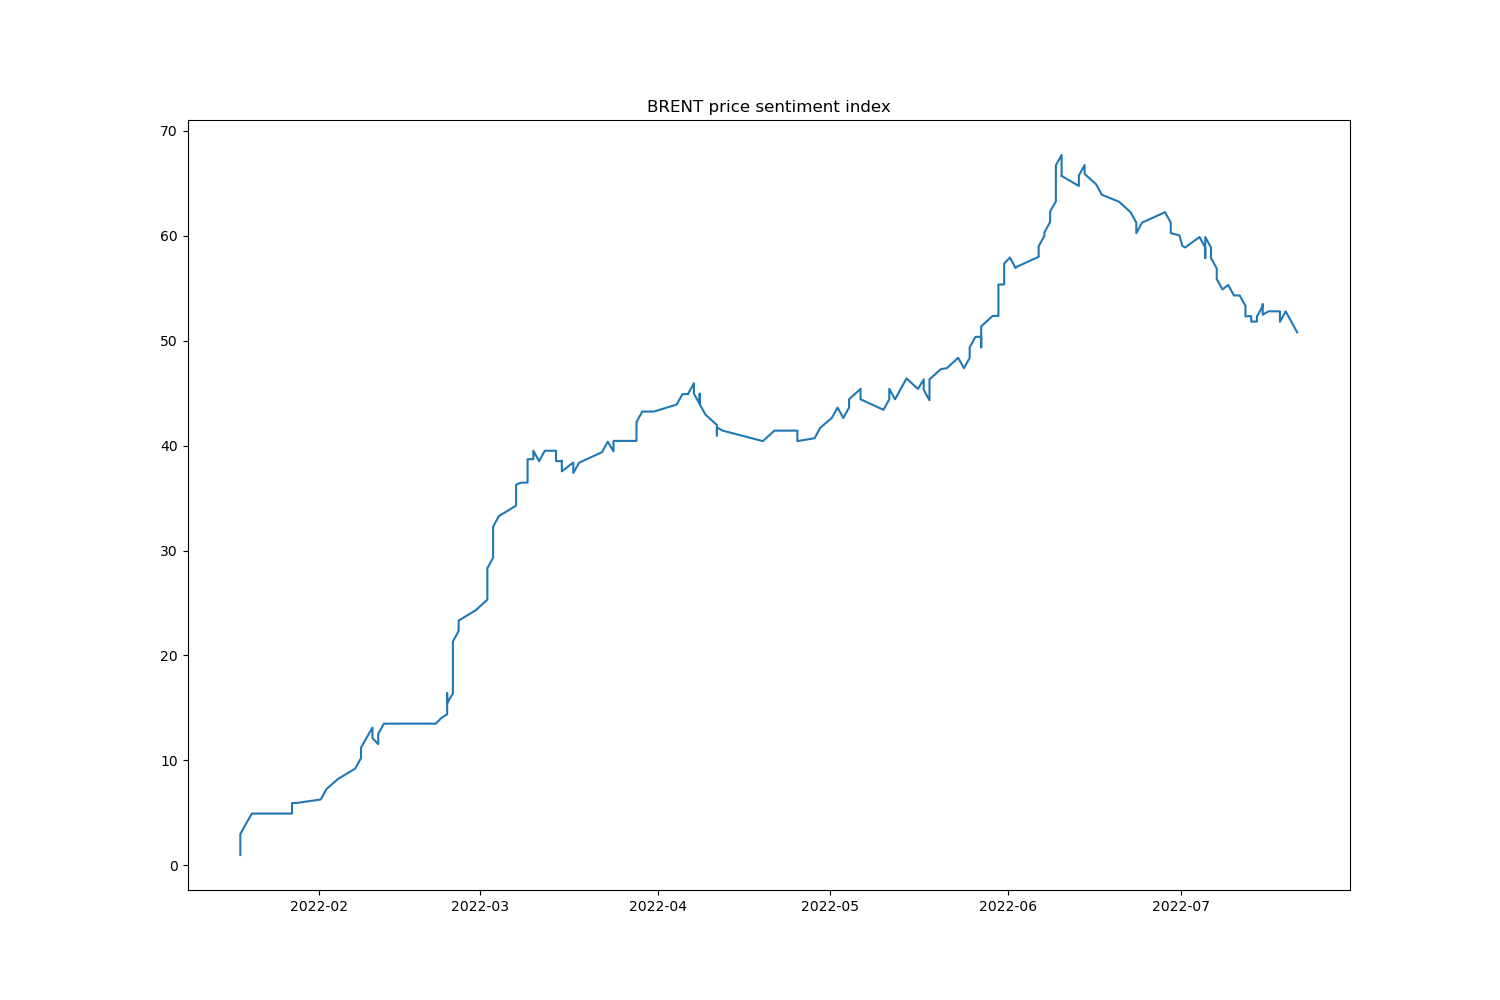

In [18]:
%matplotlib widget
sentiment_df = pd.read_csv(f"{data_directory}/{ticker}_{topic}_sentiment_all_headlines.csv", encoding = "ISO-8859-1")
sentiment_df["sentiment"] = 1*sentiment_df["positive"] + -1*sentiment_df["negative"]
sentiment_df["timestamp"] = pd.to_datetime(sentiment_df["timestamp"])
sentiment_df.set_index("timestamp", inplace=True)
sentiment_df.sort_index(inplace=True)
plt.figure(figsize = (15,10))
plt.plot(sentiment_df["sentiment"].cumsum())
plt.title(f"{ticker} {topic} sentiment index")
